In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Layer, BatchNormalization, GlobalAveragePooling2D 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model, Input 
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as pyo
pyo.init_notebook_mode()
import os

import imgaug.augmenters as iaa
import tensorflow as tf
np.random.seed(1)
tf.random.set_seed(1)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


Only 34 symbols have been used in images


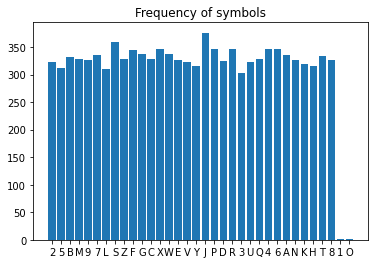

In [2]:
DIR = 'data/giro'
captcha_list = []
characters = {}
for captcha in os.listdir(DIR):
    captcha_list.append(captcha)

    captcha_code = captcha.split(".")[0]
    for i in captcha_code:
        characters[i] = characters.get(i, 0) +1
symbols = list(characters.keys())
len_symbols = len(symbols)
print(f'Only {len_symbols} symbols have been used in images')

plt.bar(*zip(*characters.items()))
plt.title('Frequency of symbols')
plt.show()

In [3]:
channels = 1
img_shape = (60, 160, channels)

nSamples = len(captcha_list) # the number of samples 'captchas'
len_captcha = 6

X = np.zeros((nSamples, 60, 160, channels)) # 1070 * 50 * 200
y = np.zeros((6, nSamples, len_symbols)) # 5 * 1070 * 19

In [4]:
for i, captcha in enumerate(captcha_list):
    captcha_code = captcha.split('.')[0]
    captcha_cv2 = cv2.imread(os.path.join(DIR, captcha),cv2.IMREAD_GRAYSCALE)
    captcha_cv2 = captcha_cv2 / 255.0
    
    captcha_cv2 = np.reshape(captcha_cv2, img_shape)
    targs = np.zeros((len_captcha, len_symbols))
    
    for a, b in enumerate(captcha_code):
        targs[a, symbols.index(b)] = 1
    X[i] = captcha_cv2
    y[:, i] = targs

In [5]:
print("shape of X:", X.shape)
print("shape of y:", y.shape)

shape of X: (1769, 60, 160, 1)
shape of y: (6, 1769, 34)


In [6]:
from numpy.random import default_rng

rng = default_rng(seed=1)
test_numbers = rng.choice(1769, size=int(1769*0.2), replace=False)

X_test = X[test_numbers]
X_full = np.delete(X, test_numbers,0)
y_test = y[:,test_numbers]
y_full = np.delete(y, test_numbers,1)

val_numbers = rng.choice(int(1769*0.7), size=int(1769*0.2), replace=False)

X_val = X_full[val_numbers]
X_train = np.delete(X_full, val_numbers,0)
y_val = y_full[:,val_numbers]
y_train = np.delete(y_full, val_numbers,1)

In [7]:
print('Samples in train set:',X_train.shape[0])
print('Samples in test set:',X_test.shape[0])
print('Samples in validation set:',X_val.shape[0])

Samples in train set: 1063
Samples in test set: 353
Samples in validation set: 353


In [8]:
aug =iaa.Sequential([iaa.CropAndPad(
    px=((0, 10), (0, 35), (0, 10), (0, 35)),
    pad_mode=['edge'],
    pad_cval=1
),iaa.Rotate(rotate=(-8,8))])



X_aug_train = None
y_aug_train = y_train
for i in range(40):
    X_aug = aug(images = X_train)
    if X_aug_train is not None:
        X_aug_train = np.concatenate([X_aug_train, X_aug], axis = 0)
        y_aug_train = np.concatenate([y_aug_train, y_train], axis = 1)
    else:
        X_aug_train = X_aug

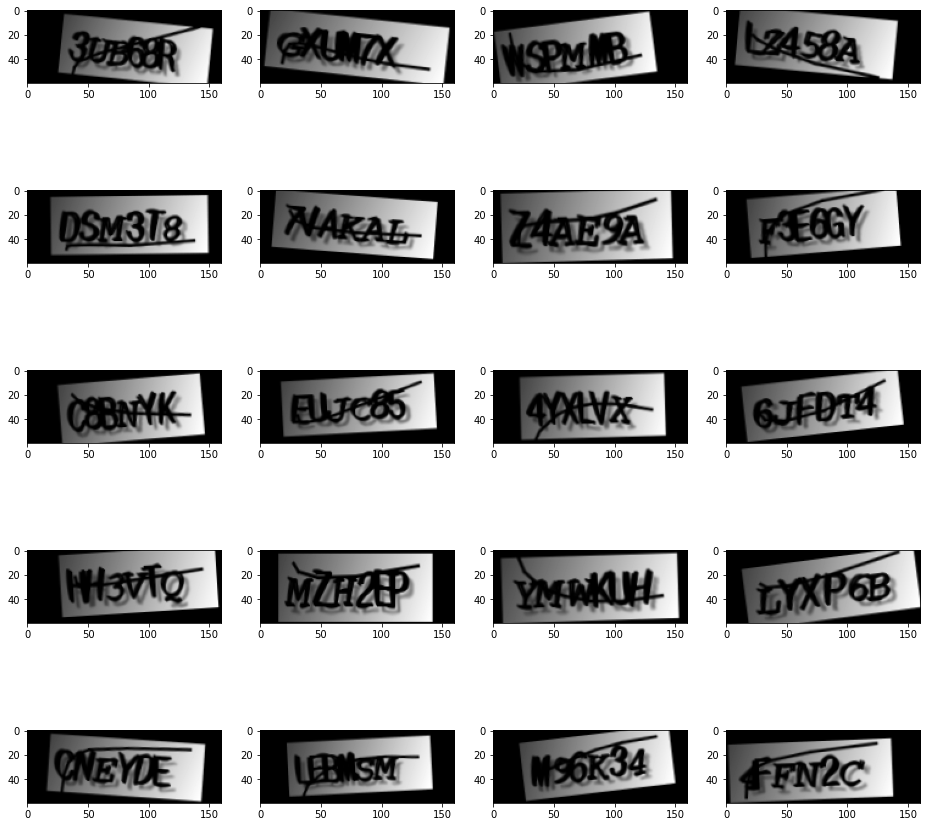

In [9]:
fig, ax = plt.subplots(nrows=5, ncols =4, figsize = (16,16))
for i in range(20):
    index = np.random.randint(X_aug_train.shape[0])
    ax[i//4][i%4].imshow(X_aug_train[index],cmap='gray')

In [10]:
captcha = Input(shape=(60,160,channels))
x = Conv2D(32, (5,5),padding='valid',activation='relu')(captcha)
x = MaxPooling2D((2,2),padding='same')(x)
x = Conv2D(64, (3,3),padding='same',activation='relu')(x)
x = MaxPooling2D((2,2),padding='same')(x)
x = Conv2D(128, (3,3),padding='same',activation='relu')(x)
maxpool = MaxPooling2D((2,2),padding='same')(x)
outputs = []
for i in range(6):
    x = Conv2D(256, (3,3),padding='same',activation='relu')(maxpool)
    x = MaxPooling2D((2,2),padding='same')(x)
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    x = Dense(len_symbols , activation='softmax' , name=f'char_{i+1}')(x)
    outputs.append(x)
    
model = Model(inputs = captcha , outputs=outputs)

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60, 160, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 56, 156, 32)  832         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 28, 78, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 78, 64)   18496       max_pooling2d[0][0]              
______________________________________________________________________________________________

In [12]:
reduce_lr = ReduceLROnPlateau(patience =3, factor = 0.5,verbose = 1)
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0005), metrics=["accuracy"])
earlystopping = EarlyStopping(monitor ="val_loss",  
                             mode ="min", patience = 10,
                              min_delta = 1e-4,
                             restore_best_weights = True) 

# history = model.fit(X_aug_train, [y_aug_train[i] for i in range(5)], batch_size=32, epochs=50, verbose=1, validation_data = (X_val, [y_val[i] for i in range(5)]), callbacks =[earlystopping,reduce_lr])
history = model.fit(X_aug_train, [y_aug_train[i] for i in range(6)], batch_size=128, epochs=20, verbose=1, validation_data = (X_val, [y_val[i] for i in range(6)]), callbacks =[earlystopping,reduce_lr])

Epoch 1/20
333/333 [==============================] - 23s 57ms/step - loss: 21.4044 - char_1_loss: 3.5002 - char_2_loss: 3.6197 - char_3_loss: 3.5881 - char_4_loss: 3.5885 - char_5_loss: 3.5785 - char_6_loss: 3.5294 - char_1_accuracy: 0.0963 - char_2_accuracy: 0.0729 - char_3_accuracy: 0.0749 - char_4_accuracy: 0.0829 - char_5_accuracy: 0.0785 - char_6_accuracy: 0.0877 - val_loss: 19.8124 - val_char_1_loss: 3.2905 - val_char_2_loss: 3.3048 - val_char_3_loss: 3.3054 - val_char_4_loss: 3.2904 - val_char_5_loss: 3.3104 - val_char_6_loss: 3.3110 - val_char_1_accuracy: 0.1105 - val_char_2_accuracy: 0.1076 - val_char_3_accuracy: 0.0708 - val_char_4_accuracy: 0.0765 - val_char_5_accuracy: 0.1048 - val_char_6_accuracy: 0.0680
Epoch 2/20
333/333 [==============================] - 18s 55ms/step - loss: 12.3736 - char_1_loss: 1.6936 - char_2_loss: 2.3241 - char_3_loss: 2.3450 - char_4_loss: 2.3139 - char_5_loss: 2.1763 - char_6_loss: 1.5208 - char_1_accuracy: 0.5618 - char_2_accuracy: 0.3625 - ch

Epoch 12/20
333/333 [==============================] - 18s 53ms/step - loss: 0.3792 - char_1_loss: 0.0408 - char_2_loss: 0.0626 - char_3_loss: 0.0780 - char_4_loss: 0.0948 - char_5_loss: 0.0707 - char_6_loss: 0.0322 - char_1_accuracy: 0.9928 - char_2_accuracy: 0.9872 - char_3_accuracy: 0.9827 - char_4_accuracy: 0.9776 - char_5_accuracy: 0.9851 - char_6_accuracy: 0.9934 - val_loss: 2.2605 - val_char_1_loss: 0.2857 - val_char_2_loss: 0.2604 - val_char_3_loss: 0.4893 - val_char_4_loss: 0.7285 - val_char_5_loss: 0.4005 - val_char_6_loss: 0.0961 - val_char_1_accuracy: 0.9660 - val_char_2_accuracy: 0.9377 - val_char_3_accuracy: 0.8725 - val_char_4_accuracy: 0.8300 - val_char_5_accuracy: 0.8895 - val_char_6_accuracy: 0.9745
Epoch 13/20
333/333 [==============================] - 18s 54ms/step - loss: 0.3421 - char_1_loss: 0.0379 - char_2_loss: 0.0572 - char_3_loss: 0.0707 - char_4_loss: 0.0822 - char_5_loss: 0.0662 - char_6_loss: 0.0279 - char_1_accuracy: 0.9923 - char_2_accuracy: 0.9871 - cha

In [13]:
score = model.evaluate(X_test,[y_test[0], y_test[1], y_test[2], y_test[3], y_test[4], y_test[5]],verbose=1)
metrics = ['loss','char_1_loss', 'char_2_loss', 'char_3_loss', 'char_4_loss', 'char_5_loss', 'char_6_loss', 'char_1_acc', 'char_2_acc', 'char_3_acc', 'char_4_acc', 'char_5_acc', 'char_6_acc']

for i,j in zip(metrics, score):
    print(f'{i}: {j}')

12/12 [==============================] - 0s 15ms/step - loss: 1.7051 - char_1_loss: 0.0162 - char_2_loss: 0.1926 - char_3_loss: 0.3444 - char_4_loss: 0.6149 - char_5_loss: 0.4437 - char_6_loss: 0.0932 - char_1_accuracy: 0.9915 - char_2_accuracy: 0.9405 - char_3_accuracy: 0.9122 - char_4_accuracy: 0.8612 - char_5_accuracy: 0.9150 - char_6_accuracy: 0.9773
loss: 1.7050515413284302
char_1_loss: 0.016238706186413765
char_2_loss: 0.19261698424816132
char_3_loss: 0.34440872073173523
char_4_loss: 0.6148945093154907
char_5_loss: 0.44372013211250305
char_6_loss: 0.09317244589328766
char_1_acc: 0.9915013909339905
char_2_acc: 0.9405099153518677
char_3_acc: 0.9121813178062439
char_4_acc: 0.8611897826194763
char_5_acc: 0.9150141477584839
char_6_acc: 0.977337121963501


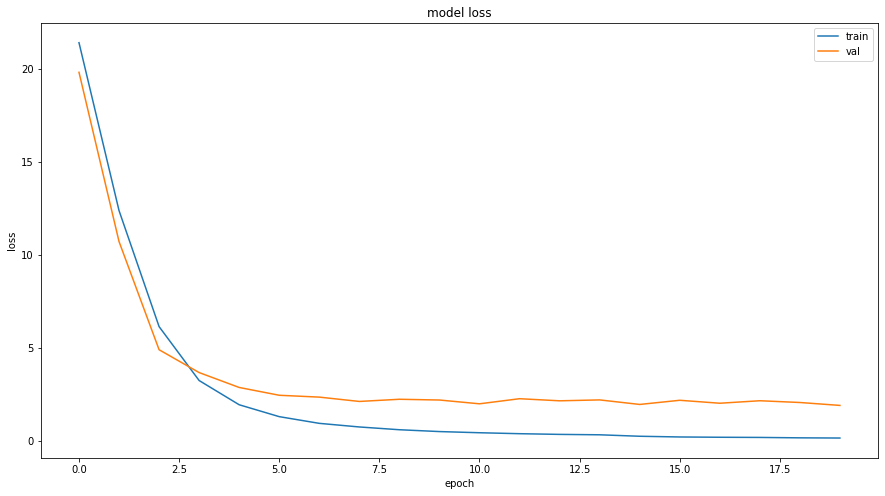

In [14]:
plt.figure(figsize=(15,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right',prop={'size': 10})
plt.show()

In [15]:
# Define function to predict captcha
def predict(filepath, model):
    img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        img = img / 255.0
    else:
        print("Not detected");
    res = np.array(model.predict(img[np.newaxis, :, :, np.newaxis]))
    ans = np.reshape(res, (6, len_symbols))
    l_ind = []
    probs = []
    for a in ans:
        l_ind.append(np.argmax(a))
        #probs.append(np.max(a))

    capt = ''
    for l in l_ind:
        capt += symbols[l]
    return capt#, sum(probs) / 5


In [16]:
print(predict('data/test/2KRU63.png', model))
print(predict('data/test/2YU6WY.png', model))
print(predict('data/test/4MCQXL.png', model))
print(predict('data/test/7KD3FJ.png', model))
print(predict('data/test/RQWJFQ.png', model))
print(predict('data/test/RZGMYU.png', model))
print(predict('data/test/SU8AJ8.png', model))
print(predict('data/test/ZZGXKX.png', model))
print(predict('data/test/VWPNTN.png', model))
print(predict('data/test/W2JTH6.png', model))


2KRU63
2YU6WY
4MQQXL
7KD3FJ
RQWJFQ
RZGMYU
SU8AJ8
ZZGXKX
VWPPTN
W2JTH6
